In [52]:
from google.colab import drive
drive.mount('/content/drive')

Drive already mounted at /content/drive; to attempt to forcibly remount, call drive.mount("/content/drive", force_remount=True).


In [2]:
import matplotlib.image as mpimg
import matplotlib.pyplot as plt
import numpy as np
import os
import textwrap
import torch
import torchvision.transforms as transforms
from sklearn.model_selection import train_test_split
from torchvision import datasets, transforms
from torchvision import datasets, transforms
from tqdm import tqdm # progress bar

# update file location

In [5]:
base_dir = '/content/drive/MyDrive/DLdata2'
color_dir = base_dir + '/color/Corn_(maize)___Northern_Leaf_Blight'
grayscale_dir = base_dir + '/grayscale/Corn_(maize)___Northern_Leaf_Blight'
segmented_dir = base_dir + '/segmented/Corn_(maize)___Northern_Leaf_Blight'
data_dir = '/content/drive/MyDrive/DLdata2/color'

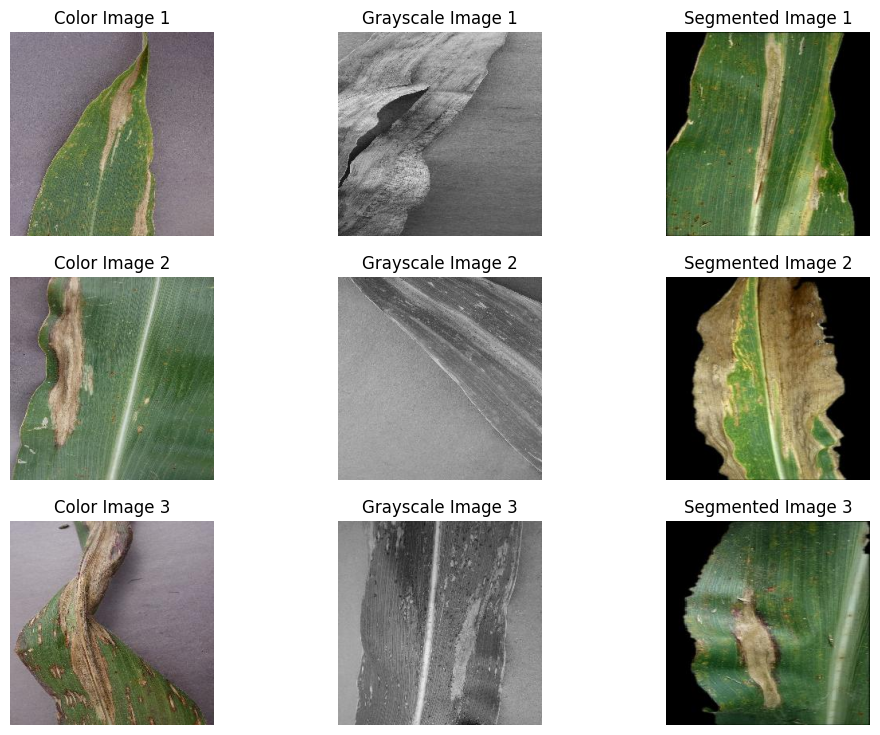

In [4]:
def display_sample_images(color_dir, grayscale_dir, segmented_dir, num_images=3):
    color_files = os.listdir(color_dir)[:num_images]
    grayscale_files = os.listdir(grayscale_dir)[:num_images]
    segmented_files = os.listdir(segmented_dir)[:num_images]

    plt.figure(figsize=(12, 3*num_images))
    for i, (color_file, grayscale_file, segmented_file) in enumerate(zip(color_files, grayscale_files, segmented_files), start=1):

        plt.subplot(num_images, 3, i*3-2)
        color_img = mpimg.imread(os.path.join(color_dir, color_file))
        plt.imshow(color_img)
        plt.title(f'Color Image {i}')
        plt.axis('off')

        plt.subplot(num_images, 3, i*3-1)
        grayscale_img = mpimg.imread(os.path.join(grayscale_dir, grayscale_file))
        plt.imshow(grayscale_img, cmap='gray')
        plt.title(f'Grayscale Image {i}')
        plt.axis('off')

        plt.subplot(num_images, 3, i*3)
        segmented_img = mpimg.imread(os.path.join(segmented_dir, segmented_file))
        plt.imshow(segmented_img)
        plt.title(f'Segmented Image {i}')
        plt.axis('off')

    plt.subplots_adjust(wspace=0.2, hspace=0.2)
    plt.show()

# Specify the directories for each dataset
# base_dir = '/content/drive/MyDrive/634_Deep_Learning_Project_Shared/data/raw_data/other/'
#     # Specify the directories for each dataset
# base_dir = '/content/drive/MyDrive/DLdata2'
# color_dir = base_dir + '/color/Corn_(maize)___Northern_Leaf_Blight'
# grayscale_dir = base_dir + '/grayscale/Corn_(maize)___Northern_Leaf_Blight'
# segmented_dir = base_dir + '/segmented/Corn_(maize)___Northern_Leaf_Blight'

# Display sample images from each dataset
display_sample_images(color_dir, grayscale_dir, segmented_dir)


In [6]:
class CustomImageFolder(datasets.ImageFolder):
    @staticmethod
    def make_dataset(directory, class_to_idx, extensions=None, is_valid_file=None):
        """
        Overridden method to create a dataset from the directory.
        """
        instances = []
        directory = os.path.expanduser(directory)
        if not ((extensions is None) or isinstance(extensions, str)):
            extensions = tuple(extensions)
        if extensions is not None:
            def is_valid_file(x):
                return datasets.folder.has_file_allowed_extension(x, extensions)
        else:
            def is_valid_file(x):
                return True
        for target_class in sorted(class_to_idx.keys()):
            class_index = class_to_idx[target_class]
            target_dir = os.path.join(directory, target_class)
            if not os.path.isdir(target_dir):
                continue
            for root, _, fnames in sorted(os.walk(target_dir, followlinks=True)):
                for fname in sorted(fnames):
                    path = os.path.join(root, fname)
                    if is_valid_file(path):
                        item = path, class_index
                        instances.append(item)
        return instances

In [7]:
dataset = CustomImageFolder(root=data_dir)

## Verify file path to load preproceseed data



In [8]:
import numpy as np

# Load data
# train_data = np.load('../../data/plantvillage dataset/preprocessed_data/train_data.npy')
# train_labels = np.load('../../data/plantvillage dataset/preprocessed_data/train_labels.npy')
# val_data = np.load('../../data/plantvillage dataset/preprocessed_data/val_data.npy')
# val_labels = np.load('../../data/plantvillage dataset/preprocessed_data/val_labels.npy')
# test_data = np.load('../../data/plantvillage dataset/preprocessed_data/test_data.npy')
# test_labels = np.load('../../data/plantvillage dataset/preprocessed_data/test_labels.npy')
preprocessed_dir =  '/content/drive/MyDrive/DLdata2/preprocessed_data/'
train_data = np.load(preprocessed_dir +'train_data.npy')
train_labels = np.load(preprocessed_dir+'train_labels.npy')
val_data = np.load(preprocessed_dir+'val_data.npy')
val_labels = np.load(preprocessed_dir+'val_labels.npy')
test_data = np.load(preprocessed_dir+'test_data.npy')
test_labels = np.load(preprocessed_dir+'test_labels.npy')


In [9]:
# Imports
import matplotlib.pyplot as plt
import numpy as np
import torch
import torch.nn as nn
import torch.optim as optim
from torch.utils.data import DataLoader, TensorDataset
from sklearn.metrics import f1_score

In [10]:
# Convert numpy arrays to PyTorch tensors
train_dataset = TensorDataset(torch.from_numpy(train_data), torch.from_numpy(train_labels))
val_dataset = TensorDataset(torch.from_numpy(val_data), torch.from_numpy(val_labels))
test_dataset = TensorDataset(torch.from_numpy(test_data), torch.from_numpy(test_labels))

# Define data loaders
batch_size = 64
train_loader = DataLoader(train_dataset, batch_size=batch_size, shuffle=True)
val_loader = DataLoader(val_dataset, batch_size=batch_size, shuffle=False)
test_loader = DataLoader(test_dataset, batch_size=batch_size, shuffle=False)


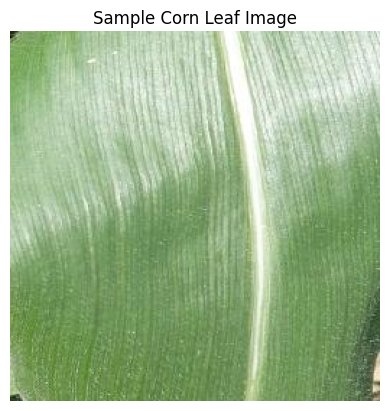

In [11]:
sample_image = train_data[10]

# Display the sample image
plt.imshow(sample_image.transpose(1, 2, 0))  # Transpose the dimensions for displaying with matplotlib
plt.title('Sample Corn Leaf Image')
plt.axis('off')  # Turn off axis
plt.show()


In [73]:
# Calculate class frequencies
unique_classes, class_counts = np.unique(train_labels, return_counts=True)

# Calculate total number of samples
total_samples = len(train_labels)

# Calculate class weights using the provided formula
class_weights_dict = {cls: 1 - (count / total_samples) for cls, count in zip(unique_classes, class_counts)}
class_weights = list(class_weights_dict.values())
number_of_classes = 4
print("Class weights:", class_weights)

Class weights: [0.8668397626112759, 0.6906528189910979, 0.7440652818991098, 0.6984421364985163]


## Amadeos baseline model



In [13]:
# Define the shallow neural network model
class ShallowNN(nn.Module):
    def __init__(self):
        super(ShallowNN, self).__init__()
        self.flatten = nn.Flatten()
        self.fc1 = nn.Linear(3 * 256 * 256, 128)
        self.fc2 = nn.Linear(128, 4)

    def forward(self, x):
        x = self.flatten(x)
        x = self.fc1(x)
        x = nn.ReLU()(x)
        x = self.fc2(x)
        return x

# Instantiate the model
model = ShallowNN()

# Define loss function and optimizer
criterion = nn.CrossEntropyLoss(weight=torch.tensor(class_weights, dtype=torch.float)) # ADDED CLASS WEIGHTS
optimizer = optim.Adam(model.parameters())

In [14]:
# Training loop
num_epochs = 10
for epoch in range(num_epochs):
    # Train the model
    model.train()
    train_loss = 0.0
    train_predictions = []
    train_targets = []
    for data, labels in train_loader:
        optimizer.zero_grad()
        outputs = model(data)
        loss = criterion(outputs, labels.long())
        loss.backward()
        optimizer.step()
        train_loss += loss.item()
        _, predicted = torch.max(outputs, 1)
        train_predictions.extend(predicted.tolist())
        train_targets.extend(labels.tolist())

    # Calculate train f1_score and loss
    train_loss /= len(train_loader)
    train_f1 = f1_score(train_targets, train_predictions, average='weighted')

    # Evaluate the model on validation set
    model.eval()
    val_loss = 0.0
    val_predictions = []
    val_targets = []
    with torch.no_grad():
        for data, labels in val_loader:
            outputs = model(data)
            loss = criterion(outputs, labels.long())
            val_loss += loss.item()
            _, predicted = torch.max(outputs, 1)
            val_predictions.extend(predicted.tolist())
            val_targets.extend(labels.tolist())

    # Calculate validation f1_score and loss
    val_loss /= len(val_loader)
    val_f1 = f1_score(val_targets, val_predictions, average='weighted')

    # Print epoch statistics
    print(f'Epoch {epoch+1}/{num_epochs}, Train Loss: {train_loss:.4f}, Train F1 Score: {train_f1:.4f}, Val Loss: {val_loss:.4f}, Val F1 Score: {val_f1:.4f}')


Epoch 1/10, Train Loss: 13.1128, Train F1 Score: 0.5467, Val Loss: 2.3770, Val F1 Score: 0.6675
Epoch 2/10, Train Loss: 2.2236, Train F1 Score: 0.7348, Val Loss: 2.2262, Val F1 Score: 0.6435
Epoch 3/10, Train Loss: 1.7329, Train F1 Score: 0.7967, Val Loss: 2.3944, Val F1 Score: 0.6410
Epoch 4/10, Train Loss: 1.5475, Train F1 Score: 0.7928, Val Loss: 1.6704, Val F1 Score: 0.6745
Epoch 5/10, Train Loss: 1.9585, Train F1 Score: 0.7784, Val Loss: 1.8581, Val F1 Score: 0.7729
Epoch 6/10, Train Loss: 0.9326, Train F1 Score: 0.8296, Val Loss: 1.2263, Val F1 Score: 0.7498
Epoch 7/10, Train Loss: 1.0234, Train F1 Score: 0.8196, Val Loss: 0.8510, Val F1 Score: 0.8083
Epoch 8/10, Train Loss: 0.4321, Train F1 Score: 0.8692, Val Loss: 0.9098, Val F1 Score: 0.7756
Epoch 9/10, Train Loss: 0.4654, Train F1 Score: 0.8685, Val Loss: 1.8524, Val F1 Score: 0.7727
Epoch 10/10, Train Loss: 0.6234, Train F1 Score: 0.8518, Val Loss: 0.5871, Val F1 Score: 0.8430


## Initial CNN Model


In [53]:
class CNNModel(nn.Module):
    def __init__(self, num_classes=4):
        super(CNNModel, self).__init__()
        self.conv1 = nn.Conv2d(3, 32, kernel_size=3, padding=1)
        self.relu1 = nn.ReLU()
        self.pool1 = nn.MaxPool2d(kernel_size=2, stride=2)
        self.conv2 = nn.Conv2d(32, 64, kernel_size=3, padding=1)
        self.relu2 = nn.ReLU()
        self.pool2 = nn.MaxPool2d(kernel_size=2, stride=2)
        self.conv3 = nn.Conv2d(64, 128, kernel_size=3, padding=1)
        self.relu3 = nn.ReLU()
        self.pool3 = nn.MaxPool2d(kernel_size=2, stride=2)
        self.flatten = nn.Flatten()
        self.fc1 = nn.Linear(128 * 32 * 32, 512)
        self.relu4 = nn.ReLU()
        self.dropout = nn.Dropout(0.5)
        self.fc2 = nn.Linear(512, num_classes)

    def forward(self, x):
        x = self.pool1(self.relu1(self.conv1(x)))
        x = self.pool2(self.relu2(self.conv2(x)))
        x = self.pool3(self.relu3(self.conv3(x)))
        x = self.flatten(x)
        x = self.dropout(self.relu4(self.fc1(x)))
        x = self.fc2(x)
        return x

In [64]:
import os
import torch
import numpy as np
import pandas as pd
from sklearn.metrics import f1_score

class ModelTrainer:
    def __init__(self, model, train_loader, val_loader,test_loader, num_classes, device, save_path, model_name):
        self.model = model.to(device)
        self.train_loader = train_loader
        self.val_loader = val_loader
        self.test_data = test_loader
        self.device = device
        self.criterion = nn.CrossEntropyLoss()  # Add weights if necessary
        self.optimizer = optim.Adam(self.model.parameters(), lr=0.001)
        self.train_losses = []
        self.val_losses = []
        self.train_f1_scores = []
        self.val_f1_scores = []
        self.save_path = save_path
        self.model_name = model_name

    def train(self, num_epochs):
        for epoch in range(num_epochs):
            self.model.train()
            total_train_loss = 0
            all_train_labels = []
            all_train_preds = []

            for data, labels in self.train_loader:
                data, labels = data.to(self.device), labels.to(self.device)
                self.optimizer.zero_grad()
                outputs = self.model(data)
                loss = self.criterion(outputs, labels.long())
                loss.backward()
                self.optimizer.step()

                total_train_loss += loss.item()
                all_train_labels.extend(labels.cpu().numpy())
                all_train_preds.extend(torch.max(outputs, 1)[1].cpu().numpy())

            train_loss = total_train_loss / len(self.train_loader)
            train_f1 = f1_score(all_train_labels, all_train_preds, average='weighted')
            self.train_losses.append(train_loss)
            self.train_f1_scores.append(train_f1)

            val_loss, val_f1 = self.validate()
            self.val_losses.append(val_loss)
            self.val_f1_scores.append(val_f1)

            print(f'Epoch {epoch + 1}/{num_epochs}, Train Loss: {train_loss:.4f}, Train F1: {train_f1:.4f}, Val Loss: {val_loss:.4f}, Val F1: {val_f1:.4f}')

        self.save_model()
        self.save_losses()
        self.generate_predictions()

    def validate(self):
        self.model.eval()
        total_val_loss = 0
        all_val_labels = []
        all_val_preds = []
        with torch.no_grad():
            for data, labels in self.val_loader:
                data, labels = data.to(self.device), labels.to(self.device)
                outputs = self.model(data)
                loss = self.criterion(outputs, labels.long())
                total_val_loss += loss.item()
                all_val_labels.extend(labels.cpu().numpy())
                all_val_preds.extend(torch.max(outputs, 1)[1].cpu().numpy())

        val_loss = total_val_loss / len(self.val_loader)
        val_f1 = f1_score(all_val_labels, all_val_preds, average='weighted')
        return val_loss, val_f1

    def save_model(self):
        model_save_path = os.path.join(self.save_path, f'{self.model_name}_model.pth')
        optimizer_save_path = os.path.join(self.save_path, f'{self.model_name}_optimizer.pth')
        torch.save({
            'model_state_dict': self.model.state_dict(),
            'model_architecture': self.model
        }, model_save_path)
        torch.save(self.optimizer.state_dict(), optimizer_save_path)
        print(f"Model and optimizer saved to {model_save_path} and {optimizer_save_path}")

    def save_losses(self):
        losses_save_path = os.path.join(self.save_path, f'{self.model_name}_losses.csv')
        data = {
            "Epoch": range(1, len(self.train_losses) + 1),
            "Train Loss": self.train_losses,
            "Train F1": self.train_f1_scores,
            "Validation Loss": self.val_losses,
            "Validation F1": self.val_f1_scores
        }
        df = pd.DataFrame(data)
        df.to_csv(losses_save_path, index=False)
        print(f"Loss and F1 data saved to {losses_save_path}")

    # def generate_predictions(self):
    #     self.model.eval()
    #     predictions_save_path = os.path.join(self.save_path, f'{self.model_name}_predictions.npy')
    #     with torch.no_grad():
    #         predictions = torch.tensor([])
    #         for data in torch.tensor(self.test_data).float().to(self.device):
    #             output = self.model(data.unsqueeze(0))  # Add batch dimension
    #             predictions = torch.cat((predictions, output), dim=0)
    #     np.save(predictions_save_path, predictions.cpu().numpy())
    #     print(f"Predictions saved to {predictions_save_path}")
    def generate_predictions(self):
      self.model.eval()
      predictions_save_path = os.path.join(self.save_path, f'{self.model_name}_predictions.npy')
      with torch.no_grad():
          predictions = torch.tensor([]).to(self.device)  # Initialize on the same device as the model
          for data, _ in self.test_data:  # Iterate over batches of data
              data = data.to(self.device)  # Move data to device
              output = self.model(data)    # Forward pass
              predictions = torch.cat((predictions, output), dim=0)
      np.save(predictions_save_path, predictions.cpu().numpy())
      print(f"Predictions saved to {predictions_save_path}")


## 332 rev


In [65]:

# Usage example
device = torch.device("cuda" if torch.cuda.is_available() else "cpu")
model = CNNModel(num_classes=4)
# train_loader = ... # Define your training DataLoader
# val_loader = ... # Define your validation DataLoader
save_path = '/content/drive/MyDrive/DLdata2/models3'
model_name = 'cnn_v1'
trainer = ModelTrainer(model, train_loader, val_loader,test_loader, 4, device, save_path , model_name)
trainer.train(10)

Epoch 1/10, Train Loss: 0.9484, Train F1: 0.6296, Val Loss: 0.6453, Val F1: 0.7275
Epoch 2/10, Train Loss: 0.3773, Train F1: 0.8327, Val Loss: 0.3608, Val F1: 0.8557
Epoch 3/10, Train Loss: 0.2694, Train F1: 0.8642, Val Loss: 0.4029, Val F1: 0.8592
Epoch 4/10, Train Loss: 0.2236, Train F1: 0.8893, Val Loss: 0.3013, Val F1: 0.8868
Epoch 5/10, Train Loss: 0.1819, Train F1: 0.9129, Val Loss: 0.3112, Val F1: 0.9012
Epoch 6/10, Train Loss: 0.1589, Train F1: 0.9285, Val Loss: 0.3588, Val F1: 0.9192
Epoch 7/10, Train Loss: 0.1347, Train F1: 0.9444, Val Loss: 0.2726, Val F1: 0.9216
Epoch 8/10, Train Loss: 0.1050, Train F1: 0.9609, Val Loss: 0.3269, Val F1: 0.9140
Epoch 9/10, Train Loss: 0.0928, Train F1: 0.9639, Val Loss: 0.2707, Val F1: 0.9301
Epoch 10/10, Train Loss: 0.0741, Train F1: 0.9690, Val Loss: 0.3664, Val F1: 0.9173
Model and optimizer saved to /content/drive/MyDrive/DLdata2/models3/cnn_v1_model.pth and /content/drive/MyDrive/DLdata2/models3/cnn_v1_optimizer.pth
Loss and F1 data sav

In [20]:
# device = torch.device("cuda" if torch.cuda.is_available() else "cpu")
# model = CNNModel(num_classes=4)
# save_path = '/content/drive/MyDrive/DLdata2/models_data'
# model_name = 'cnn_v2'
# trainer = ModelTrainer(model, train_loader, val_loader, num_classes=4, device=device, save_path=save_path, model_name=model_name)
# trainer.train(num_epochs=10)


Epoch 1/10, Train Loss: 0.6641, Train F1: 0.7325, Val Loss: 0.5671, Val F1: 0.7769
Epoch 2/10, Train Loss: 0.3737, Train F1: 0.8301, Val Loss: 0.2595, Val F1: 0.8796
Epoch 3/10, Train Loss: 0.2579, Train F1: 0.8926, Val Loss: 0.3145, Val F1: 0.8588
Epoch 4/10, Train Loss: 0.2041, Train F1: 0.9131, Val Loss: 0.4621, Val F1: 0.8361
Epoch 5/10, Train Loss: 0.1853, Train F1: 0.9234, Val Loss: 0.2299, Val F1: 0.9326
Epoch 6/10, Train Loss: 0.1725, Train F1: 0.9397, Val Loss: 0.2833, Val F1: 0.9253
Epoch 7/10, Train Loss: 0.1478, Train F1: 0.9428, Val Loss: 0.2327, Val F1: 0.9306
Epoch 8/10, Train Loss: 0.1297, Train F1: 0.9496, Val Loss: 0.2143, Val F1: 0.9418
Epoch 9/10, Train Loss: 0.0806, Train F1: 0.9714, Val Loss: 0.3027, Val F1: 0.9215
Epoch 10/10, Train Loss: 0.0759, Train F1: 0.9751, Val Loss: 0.2980, Val F1: 0.9325
Model saved to /content/drive/MyDrive/DLdata2/models_data/cnn_v2_model.pth
Loss and F1 data saved to /content/drive/MyDrive/DLdata2/models_data/cnn_v2_train_val_losses.c

## CNN Model 2


In [66]:

class CNNModel(nn.Module):
    def __init__(self, num_classes=4):
        super(CNNModel, self).__init__()
        self.conv1 = nn.Conv2d(3, 48, kernel_size=3, padding=1)
        self.relu1 = nn.ReLU()
        self.pool1 = nn.MaxPool2d(kernel_size=2, stride=2)
        self.conv2 = nn.Conv2d(48, 64, kernel_size=3, padding=1)
        self.relu2 = nn.ReLU()
        self.pool2 = nn.MaxPool2d(kernel_size=2, stride=2)
        self.conv3 = nn.Conv2d(64, 128, kernel_size=3, padding=1)
        self.relu3 = nn.ReLU()
        self.pool3 = nn.MaxPool2d(kernel_size=2, stride=2)
        self.flatten = nn.Flatten()
        self.fc1 = nn.Linear(128 * 32 * 32, 512)  # Adjust the input dimensions based on your image size and pooling layers
        self.relu4 = nn.ReLU()
        self.dropout = nn.Dropout(0.2)
        self.fc2 = nn.Linear(512, num_classes)

    def forward(self, x):
        x = self.pool1(self.relu1(self.conv1(x)))
        x = self.pool2(self.relu2(self.conv2(x)))
        x = self.pool3(self.relu3(self.conv3(x)))
        x = self.flatten(x)
        x = self.dropout(self.relu4(self.fc1(x)))
        x = self.fc2(x)
        return x

In [67]:

# Usage example
device = torch.device("cuda" if torch.cuda.is_available() else "cpu")
model = CNNModel(num_classes=4)
# train_loader = ... # Define your training DataLoader
# val_loader = ... # Define your validation DataLoader
save_path = '/content/drive/MyDrive/DLdata2/models3'
model_name = 'cnn_v2'
trainer = ModelTrainer(model, train_loader, val_loader,test_loader, 4, device, save_path , model_name)
trainer.train(10)

Epoch 1/10, Train Loss: 0.7842, Train F1: 0.6874, Val Loss: 0.4909, Val F1: 0.7585
Epoch 2/10, Train Loss: 0.3446, Train F1: 0.8336, Val Loss: 0.3162, Val F1: 0.8776
Epoch 3/10, Train Loss: 0.2377, Train F1: 0.8839, Val Loss: 0.4115, Val F1: 0.8509
Epoch 4/10, Train Loss: 0.1929, Train F1: 0.9155, Val Loss: 0.2491, Val F1: 0.9149
Epoch 5/10, Train Loss: 0.1548, Train F1: 0.9357, Val Loss: 0.2783, Val F1: 0.9055
Epoch 6/10, Train Loss: 0.1581, Train F1: 0.9295, Val Loss: 0.2487, Val F1: 0.9213
Epoch 7/10, Train Loss: 0.1082, Train F1: 0.9529, Val Loss: 0.2304, Val F1: 0.9223
Epoch 8/10, Train Loss: 0.1056, Train F1: 0.9556, Val Loss: 0.2351, Val F1: 0.9334
Epoch 9/10, Train Loss: 0.0935, Train F1: 0.9632, Val Loss: 0.3318, Val F1: 0.9032
Epoch 10/10, Train Loss: 0.0760, Train F1: 0.9680, Val Loss: 0.3219, Val F1: 0.9227
Model and optimizer saved to /content/drive/MyDrive/DLdata2/models3/cnn_v2_model.pth and /content/drive/MyDrive/DLdata2/models3/cnn_v2_optimizer.pth
Loss and F1 data sav

In [25]:
# device = torch.device("cuda" if torch.cuda.is_available() else "cpu")
# model_v2 = CNNModel(num_classes=4)
# save_path = '/content/drive/MyDrive/DLdata2/models_data'
# model_name = 'cnn_v3'

# # Instantiate the ModelTrainer with the new model
# trainer_v2 = ModelTrainer(model_v2, train_loader, val_loader, num_classes=4, device=device, save_path=save_path, model_name=model_name)

# # Train the model
# trainer_v2.train(num_epochs=10)


Epoch 1/10, Train Loss: 0.7187, Train F1: 0.6813, Val Loss: 0.3503, Val F1: 0.8504
Epoch 2/10, Train Loss: 0.2812, Train F1: 0.8676, Val Loss: 0.4145, Val F1: 0.8338
Epoch 3/10, Train Loss: 0.2580, Train F1: 0.8928, Val Loss: 1.8050, Val F1: 0.5989
Epoch 4/10, Train Loss: 0.2793, Train F1: 0.8851, Val Loss: 0.3394, Val F1: 0.8579
Epoch 5/10, Train Loss: 0.1828, Train F1: 0.9348, Val Loss: 0.2612, Val F1: 0.9318
Epoch 6/10, Train Loss: 0.1409, Train F1: 0.9487, Val Loss: 0.2817, Val F1: 0.9396
Epoch 7/10, Train Loss: 0.1188, Train F1: 0.9578, Val Loss: 0.3567, Val F1: 0.9187
Epoch 8/10, Train Loss: 0.1318, Train F1: 0.9549, Val Loss: 0.3409, Val F1: 0.9190
Epoch 9/10, Train Loss: 0.1054, Train F1: 0.9661, Val Loss: 0.3859, Val F1: 0.9167
Epoch 10/10, Train Loss: 0.0883, Train F1: 0.9711, Val Loss: 0.3050, Val F1: 0.9031
Model saved to /content/drive/MyDrive/DLdata2/models_data/cnn_v3_model.pth
Loss and F1 data saved to /content/drive/MyDrive/DLdata2/models_data/cnn_v3_train_val_losses.c

## Resnet initial model

In [29]:
import torch
import torch.nn as nn
import torch.optim as optim
from torchvision import models
from torch.utils.data import DataLoader, TensorDataset


In [70]:
# Load pre-trained ResNet50
model = models.resnet50(pretrained=True)

# Freeze all layers in the network
for param in model.parameters():
    param.requires_grad = False

# Replace the final fully connected layer
num_features = model.fc.in_features
model.fc = nn.Linear(num_features, 4)  # Adjust the number of output classes to 4

# Move the model to GPU if available
device = torch.device("cuda" if torch.cuda.is_available() else "cpu")
model.to(device)

# Define the loss function and optimizer
# criterion = nn.CrossEntropyLoss()
# Only optimize the parameters of the final layer
class_weights_tensor = torch.tensor(class_weights, dtype=torch.float).to(device)
criterion = nn.CrossEntropyLoss(weight=class_weights_tensor)
optimizer = optim.Adam(model.fc.parameters(), lr=0.001)

/usr/local/lib/python3.10/dist-packages/torchvision/models/_utils.py:208: UserWarning: The parameter 'pretrained' is deprecated since 0.13 and may be removed in the future, please use 'weights' instead.
  warnings.warn(
/usr/local/lib/python3.10/dist-packages/torchvision/models/_utils.py:223: UserWarning: Arguments other than a weight enum or `None` for 'weights' are deprecated since 0.13 and may be removed in the future. The current behavior is equivalent to passing `weights=ResNet50_Weights.IMAGENET1K_V1`. You can also use `weights=ResNet50_Weights.DEFAULT` to get the most up-to-date weights.
  warnings.warn(msg)


In [37]:
# class ModelTrainer:
#     def __init__(self, model, train_loader, val_loader, num_classes, device, save_path, model_name):
#         self.model = model.to(device)
#         self.train_loader = train_loader
#         self.val_loader = val_loader
#         self.device = device
#         self.num_classes = num_classes
#         self.save_path = save_path
#         self.model_name = model_name
#         self.criterion = nn.CrossEntropyLoss()
#         self.optimizer = optim.Adam(model.fc.parameters(), lr=0.001)
#         self.train_losses = []
#         self.val_losses = []
#         self.train_f1_scores = []
#         self.val_f1_scores = []

#     def train(self, num_epochs):
#         for epoch in range(num_epochs):
#             self.model.train()
#             total_train_loss = 0
#             all_train_labels, all_train_preds = [], []

#             for data, labels in self.train_loader:
#                 data, labels = data.to(self.device), labels.to(self.device).long()  # Convert labels to long

#                 self.optimizer.zero_grad()
#                 outputs = self.model(data)
#                 loss = self.criterion(outputs, labels)
#                 loss.backward()
#                 self.optimizer.step()

#                 total_train_loss += loss.item()
#                 _, preds = torch.max(outputs, 1)
#                 all_train_labels.extend(labels.cpu().numpy())
#                 all_train_preds.extend(preds.cpu().numpy())

#             train_f1 = f1_score(all_train_labels, all_train_preds, average='weighted')
#             self.train_losses.append(total_train_loss / len(self.train_loader))
#             self.train_f1_scores.append(train_f1)

#             # Validation phase
#             model.eval()
#             total_val_loss = 0
#             all_val_labels, all_val_preds = [], []
#             with torch.no_grad():
#                 for data, labels in self.val_loader:
#                     data, labels = data.to(self.device), labels.to(self.device).long()  # Convert labels to long
#                     outputs = self.model(data)
#                     val_loss = self.criterion(outputs, labels)
#                     total_val_loss += val_loss.item()
#                     _, preds = torch.max(outputs, 1)
#                     all_val_labels.extend(labels.cpu().numpy())
#                     all_val_preds.extend(preds.cpu().numpy())

#             val_f1 = f1_score(all_val_labels, all_val_preds, average='weighted')
#             self.val_losses.append(total_val_loss / len(self.val_loader))
#             self.val_f1_scores.append(val_f1)

#             print(f'Epoch {epoch + 1}/{num_epochs}, Train Loss: {self.train_losses[-1]:.4f}, Train F1: {train_f1:.4f}, Val Loss: {self.val_losses[-1]:.4f}, Val F1: {val_f1:.4f}')

#         # Saving model and loss metrics
#         self.save_model()
#         self.save_losses()

#     def save_model(self):
#         model_path = f'{self.save_path}/{self.model_name}_model.pth'
#         torch.save({
#             'model_state_dict': self.model.state_dict(),
#             'model_architecture': self.model
#         }, model_path)
#         print(f"Model saved to {model_path}")

#     def save_losses(self):
#         losses_path = f'{self.save_path}/{self.model_name}_losses.csv'
#         pd.DataFrame({
#             'Epoch': range(1, len(self.train_losses) + 1),
#             'Train Loss': self.train_losses,
#             'Validation Loss': self.val_losses,
#             'Train F1': self.train_f1_scores,
#             'Validation F1': self.val_f1_scores
#         }).to_csv(losses_path, index=False)
#         print(f"Losses saved to {losses_path}")



In [71]:

# Usage example
device = torch.device("cuda" if torch.cuda.is_available() else "cpu")
# model = CNNModel(num_classes=4)
# train_loader = ... # Define your training DataLoader
# val_loader = ... # Define your validation DataLoader
save_path = '/content/drive/MyDrive/DLdata2/models3'
model_name = 'resnet_v1'
trainer = ModelTrainer(model, train_loader, val_loader,test_loader, 4, device, save_path , model_name)
trainer.train(10)

Epoch 1/10, Train Loss: 0.5327, Train F1: 0.8125, Val Loss: 0.2274, Val F1: 0.9136
Epoch 2/10, Train Loss: 0.2178, Train F1: 0.9371, Val Loss: 0.1663, Val F1: 0.9495
Epoch 3/10, Train Loss: 0.1823, Train F1: 0.9400, Val Loss: 0.1577, Val F1: 0.9429
Epoch 4/10, Train Loss: 0.1689, Train F1: 0.9364, Val Loss: 0.1325, Val F1: 0.9515
Epoch 5/10, Train Loss: 0.1404, Train F1: 0.9507, Val Loss: 0.1254, Val F1: 0.9482
Epoch 6/10, Train Loss: 0.1358, Train F1: 0.9484, Val Loss: 0.1189, Val F1: 0.9531
Epoch 7/10, Train Loss: 0.1299, Train F1: 0.9562, Val Loss: 0.1107, Val F1: 0.9551
Epoch 8/10, Train Loss: 0.1161, Train F1: 0.9594, Val Loss: 0.1110, Val F1: 0.9567
Epoch 9/10, Train Loss: 0.1151, Train F1: 0.9549, Val Loss: 0.1047, Val F1: 0.9519
Epoch 10/10, Train Loss: 0.1098, Train F1: 0.9581, Val Loss: 0.1088, Val F1: 0.9609
Model and optimizer saved to /content/drive/MyDrive/DLdata2/models3/resnet_v1_model.pth and /content/drive/MyDrive/DLdata2/models3/resnet_v1_optimizer.pth
Loss and F1 da

In [38]:
# # Assuming you've already set up your train_loader and val_loader
# # train_loader = DataLoader(train_dataset, batch_size=64, shuffle=True)
# # val_loader = DataLoader(val_dataset, batch_size=64, shuffle=False)
# save_path = '/content/drive/MyDrive/DLdata2/models_data'
# model_name = 'resnet_v1'
# # Create the trainer instance
# trainer = ModelTrainer(model, train_loader, val_loader, num_classes=4, device=device, save_path=save_path, model_name=model_name)

# # Train the model
# trainer.train(num_epochs=10)


Epoch 1/10, Train Loss: 0.1385, Train F1: 0.9501, Val Loss: 0.1149, Val F1: 0.9439
Epoch 2/10, Train Loss: 0.1211, Train F1: 0.9556, Val Loss: 0.1125, Val F1: 0.9607
Epoch 3/10, Train Loss: 0.1025, Train F1: 0.9596, Val Loss: 0.0997, Val F1: 0.9500
Epoch 4/10, Train Loss: 0.1082, Train F1: 0.9603, Val Loss: 0.0987, Val F1: 0.9567
Epoch 5/10, Train Loss: 0.0958, Train F1: 0.9637, Val Loss: 0.1035, Val F1: 0.9554
Epoch 6/10, Train Loss: 0.0935, Train F1: 0.9651, Val Loss: 0.1033, Val F1: 0.9614
Epoch 7/10, Train Loss: 0.0995, Train F1: 0.9634, Val Loss: 0.0973, Val F1: 0.9584
Epoch 8/10, Train Loss: 0.0980, Train F1: 0.9619, Val Loss: 0.0950, Val F1: 0.9533
Epoch 9/10, Train Loss: 0.0842, Train F1: 0.9691, Val Loss: 0.1055, Val F1: 0.9555
Epoch 10/10, Train Loss: 0.0865, Train F1: 0.9667, Val Loss: 0.0931, Val F1: 0.9583
Model saved to /content/drive/MyDrive/DLdata2/models_data/resnet_v1_model.pth
Losses saved to /content/drive/MyDrive/DLdata2/models_data/resnet_v1_losses.csv


## Resnet_50 model


In [75]:
# Load the pre-trained ResNeXt-50-32x4d model
model = models.resnext50_32x4d(pretrained=True)

# Freeze all layers in the network
for param in model.parameters():
    param.requires_grad = False

# Replace the final fully connected layer to match the number of classes
num_features = model.fc.in_features
model.fc = nn.Linear(num_features, 4)  # Adjust to your number of classes, e.g., 4

# Move the model to GPU if available
device = torch.device("cuda" if torch.cuda.is_available() else "cpu")
model.to(device)

# Define the loss function and optimizer for the fully connected layer
# criterion = nn.CrossEntropyLoss()   g
class_weights_tensor = torch.tensor(class_weights, dtype=torch.float).to(device)
criterion = nn.CrossEntropyLoss(weight=class_weights_tensor)
optimizer = optim.Adam(model.fc.parameters(), lr=0.001)

In [76]:

# Usage example
device = torch.device("cuda" if torch.cuda.is_available() else "cpu")
# model = CNNModel(num_classes=4)
# train_loader = ... # Define your training DataLoader
# val_loader = ... # Define your validation DataLoader
save_path = '/content/drive/MyDrive/DLdata2/models3'
model_name = 'resnet50_v1'
trainer = ModelTrainer(model, train_loader, val_loader,test_loader, 4, device, save_path , model_name)
trainer.train(10)

Epoch 1/10, Train Loss: 0.6531, Train F1: 0.7575, Val Loss: 0.3140, Val F1: 0.8364
Epoch 2/10, Train Loss: 0.2718, Train F1: 0.9187, Val Loss: 0.1946, Val F1: 0.9341
Epoch 3/10, Train Loss: 0.2117, Train F1: 0.9326, Val Loss: 0.1671, Val F1: 0.9435
Epoch 4/10, Train Loss: 0.1800, Train F1: 0.9401, Val Loss: 0.1673, Val F1: 0.9266
Epoch 5/10, Train Loss: 0.1770, Train F1: 0.9423, Val Loss: 0.1634, Val F1: 0.9311
Epoch 6/10, Train Loss: 0.1913, Train F1: 0.9325, Val Loss: 0.1324, Val F1: 0.9466
Epoch 7/10, Train Loss: 0.1353, Train F1: 0.9507, Val Loss: 0.1245, Val F1: 0.9466
Epoch 8/10, Train Loss: 0.1358, Train F1: 0.9518, Val Loss: 0.1207, Val F1: 0.9466
Epoch 9/10, Train Loss: 0.1201, Train F1: 0.9601, Val Loss: 0.1171, Val F1: 0.9524
Epoch 10/10, Train Loss: 0.1089, Train F1: 0.9675, Val Loss: 0.1121, Val F1: 0.9543
Model and optimizer saved to /content/drive/MyDrive/DLdata2/models3/resnet50_v1_model.pth and /content/drive/MyDrive/DLdata2/models3/resnet50_v1_optimizer.pth
Loss and F

In [40]:
# # Assuming you've already set up your train_loader and val_loader
# train_loader = DataLoader(train_dataset, batch_size=64, shuffle=True)
# val_loader = DataLoader(val_dataset, batch_size=64, shuffle=False)
# save_path = '/content/drive/MyDrive/DLdata2/models_data'
# model_name = 'resnet50_v1'
# # Create the trainer instance
# trainer = ModelTrainer(model, train_loader, val_loader, num_classes=4, device=device, save_path=save_path, model_name=model_name)

# # Train the model
# trainer.train(num_epochs=10)


Epoch 1/10, Train Loss: 0.6349, Train F1: 0.7859, Val Loss: 0.3146, Val F1: 0.8756
Epoch 2/10, Train Loss: 0.2630, Train F1: 0.9286, Val Loss: 0.1957, Val F1: 0.9343
Epoch 3/10, Train Loss: 0.2005, Train F1: 0.9419, Val Loss: 0.1687, Val F1: 0.9366
Epoch 4/10, Train Loss: 0.1726, Train F1: 0.9512, Val Loss: 0.1481, Val F1: 0.9425
Epoch 5/10, Train Loss: 0.1584, Train F1: 0.9507, Val Loss: 0.1356, Val F1: 0.9493
Epoch 6/10, Train Loss: 0.1410, Train F1: 0.9537, Val Loss: 0.1527, Val F1: 0.9251
Epoch 7/10, Train Loss: 0.1443, Train F1: 0.9481, Val Loss: 0.1234, Val F1: 0.9433
Epoch 8/10, Train Loss: 0.1218, Train F1: 0.9576, Val Loss: 0.1478, Val F1: 0.9346
Epoch 9/10, Train Loss: 0.1135, Train F1: 0.9627, Val Loss: 0.1163, Val F1: 0.9513
Epoch 10/10, Train Loss: 0.1114, Train F1: 0.9622, Val Loss: 0.1171, Val F1: 0.9532
Model saved to /content/drive/MyDrive/DLdata2/models_data/resnet50_v1_model.pth
Losses saved to /content/drive/MyDrive/DLdata2/models_data/resnet50_v1_losses.csv


In [41]:
def evaluate(model, data_loader, device):
    model.eval()  # Set the model to evaluation mode
    correct = 0
    total = 0
    with torch.no_grad():  # No gradients needed
        for images, labels in data_loader:
            images, labels = images.to(device), labels.to(device)
            outputs = model(images)
            _, predicted = torch.max(outputs.data, 1)
            total += labels.size(0)
            correct += (predicted == labels).sum().item()

    accuracy = 100 * correct / total
    return accuracy



Test Accuracy: 94.29065743944636%


In [41]:
base_path = '/content/drive/MyDrive/DLdata2/models_data'
cnn1=''

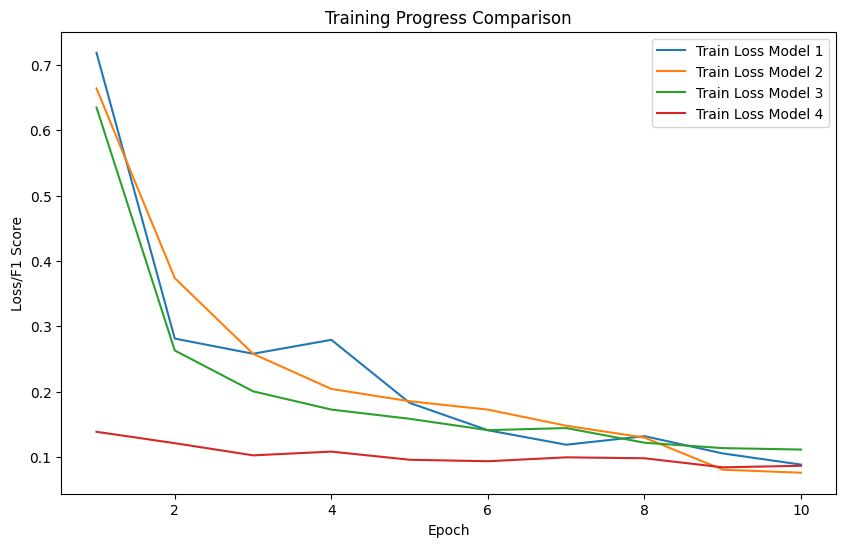

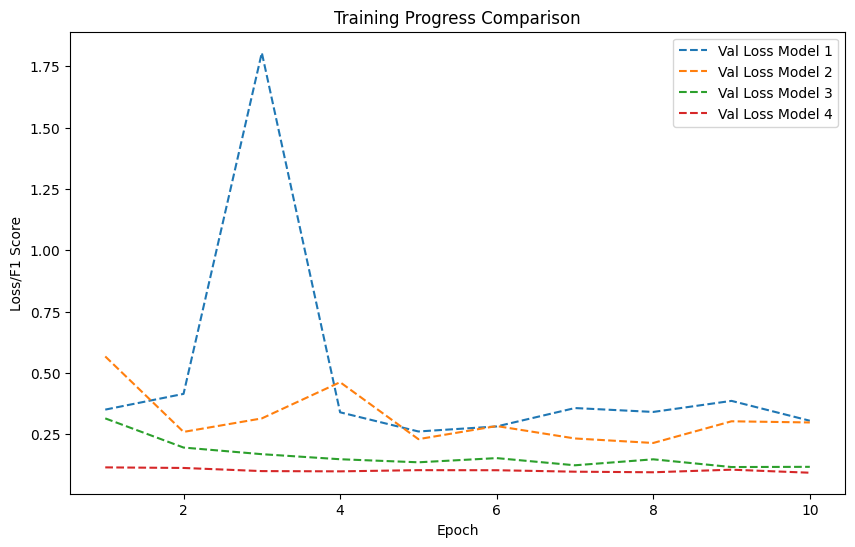

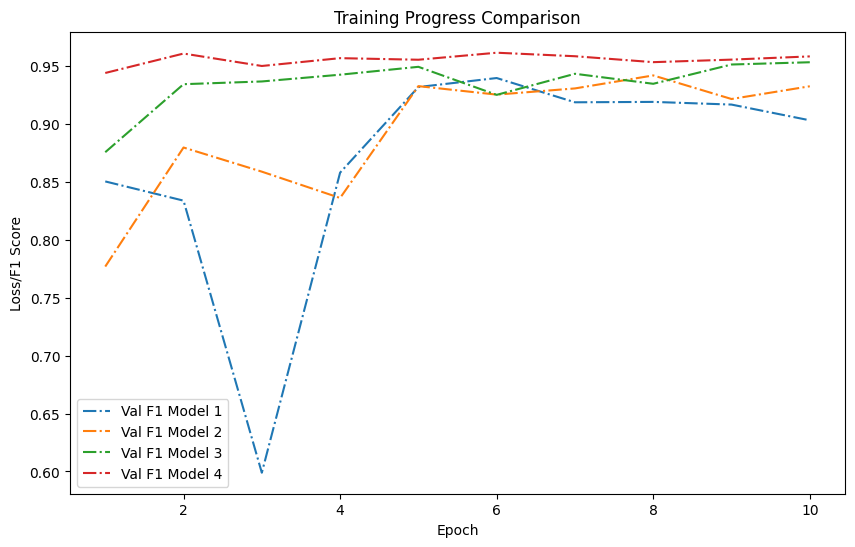

In [51]:
import pandas as pd
import matplotlib.pyplot as plt

# Paths to the CSV files
files = [
    '/content/drive/MyDrive/DLdata2/models_data/cnn_v3_train_val_losses.csv',
    '/content/drive/MyDrive/DLdata2/models_data/cnn_v2_train_val_losses.csv',
    '/content/drive/MyDrive/DLdata2/models_data/resnet50_v1_losses.csv',
    '/content/drive/MyDrive/DLdata2/models_data/resnet_v1_losses.csv'
]

labels = ['Model 1', 'Model 2', 'Model 3', 'Model 4']

# Load and prepare the data
all_data = []
for file, label in zip(files, labels):
    df = pd.read_csv(file)
    df['Model'] = label
    all_data.append(df)

# Concatenate all data into a single DataFrame
combined_data = pd.concat(all_data)

# Plotting
fig, ax = plt.subplots(figsize=(10, 6))

# Plot training losses
for label in labels:
    subset = combined_data[combined_data['Model'] == label]
    ax.plot(subset['Epoch'], subset['Train Loss'], label=f'Train Loss {label}')

# # Plot validation losses
# for label in labels:
#     subset = combined_data[combined_data['Model'] == label]
#     ax.plot(subset['Epoch'], subset['Validation Loss'], linestyle='--', label=f'Val Loss {label}')

# # Plot F1 Scores
# for label in labels:
#     subset = combined_data[combined_data['Model'] == label]
#     ax.plot(subset['Epoch'], subset['Validation F1'], linestyle='-.', label=f'Val F1 {label}')

ax.set_xlabel('Epoch')
ax.set_ylabel('Loss/F1 Score')
ax.set_title('Training Progress Comparison')
ax.legend()
plt.show()

# Plotting
fig, ax = plt.subplots(figsize=(10, 6))

# Plot validation losses
for label in labels:
    subset = combined_data[combined_data['Model'] == label]
    ax.plot(subset['Epoch'], subset['Validation Loss'], linestyle='--', label=f'Val Loss {label}')

# # Plot F1 Scores
# for label in labels:
#     subset = combined_data[combined_data['Model'] == label]
#     ax.plot(subset['Epoch'], subset['Validation F1'], linestyle='-.', label=f'Val F1 {label}')
ax.set_xlabel('Epoch')
ax.set_ylabel('Loss/F1 Score')
ax.set_title('Training Progress Comparison')
ax.legend()
plt.show()

# Plotting
fig, ax = plt.subplots(figsize=(10, 6))

# # Plot validation losses
# for label in labels:
#     subset = combined_data[combined_data['Model'] == label]
#     ax.plot(subset['Epoch'], subset['Validation Loss'], linestyle='--', label=f'Val Loss {label}')

# Plot F1 Scores
for label in labels:
    subset = combined_data[combined_data['Model'] == label]
    ax.plot(subset['Epoch'], subset['Validation F1'], linestyle='-.', label=f'Val F1 {label}')
ax.set_xlabel('Epoch')
ax.set_ylabel('Loss/F1 Score')
ax.set_title('Training Progress Comparison')
ax.legend()
plt.show()